In [1]:
import os
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os
import matplotlib.pyplot as plt
import tqdm
from torchvision import models

In [2]:
class FruitDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        
        return image, ""

In [3]:
from src.AppleModel import AppleDataset
from torchvision import transforms
from torchvision import transforms
from torch.utils.data import ConcatDataset
import tqdm

transform = transforms.Compose([
    transforms.Resize((202,308)),
    transforms.ToTensor(),
])

flip = transforms.Compose([
    transforms.Resize((202,308)),
    transforms.RandomHorizontalFlip(p=1),  # Always flip
    transforms.ToTensor(),
])

imagesApple_dir = "acfr-multifruit-2016/acfr-fruit-dataset/apples/images"
annotation_dir = "acfr-multifruit-2016/acfr-fruit-dataset/apples/annotations"

almond_dir = "acfr-multifruit-2016/acfr-fruit-dataset/almonds/images"
mango_dir = "acfr-multifruit-2016/acfr-fruit-dataset/mangoes/images"

apple = FruitDataset(imagesApple_dir,transform=transform)
applef = FruitDataset(imagesApple_dir, transform= flip)


almond = FruitDataset(almond_dir, transform=transform)
almondf = FruitDataset(almond_dir,transform=flip)

mango = FruitDataset(mango_dir, transform=transform)
mangof = FruitDataset(mango_dir, transform=flip)

dataset = ConcatDataset([apple, applef, almond, almondf, mango, mangof])

In [4]:
from utils.functions import *

#plot_random_apples(dataset)

In [5]:
from src.ColorizationDataset import ColorizationDataset
colorizationDataset = ColorizationDataset(dataset)

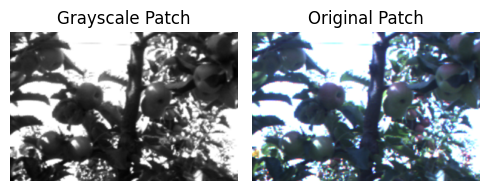

In [6]:
colorizationDataset.show(0)

In [7]:
from torch.utils.data import random_split, DataLoader

# Define the ratio for splitting the dataset into training and validation sets
train_ratio = 0.8  # 80% of the data will be used for training, 20% for validation

# Calculate the sizes of the train and validation datasets based on the ratio
dataset_size = len(colorizationDataset)  # Get the total number of samples in the dataset
train_size = int(train_ratio * dataset_size)  # Size of the training dataset
val_size = dataset_size - train_size  # Remaining data will be for the validation dataset

# Define the batch size for loading data
batch_size = 16

# Split the dataset into training and validation datasets using random_split
train_dataset, val_dataset = random_split(colorizationDataset, [train_size, val_size])

# Create DataLoader for the training dataset with shuffling enabled for randomness in training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Create DataLoader for the validation dataset without shuffling (validation data should remain fixed)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print the sizes of the train and validation datasets
print(f"Train dataset size: {len(train_dataset)}")  # Display the number of samples in the training dataset
print(f"Validation dataset size: {len(val_dataset)}")  # Display the number of samples in the validation dataset


Train dataset size: 5926
Validation dataset size: 1482


## MobileNet2 colorization model

In [22]:
import torch
import torch.nn as nn
from torchvision import models

class MobileNetV2Colorization(nn.Module):
    def __init__(self):
        super(MobileNetV2Colorization, self).__init__()
        
        # Load pre-trained MobileNetV2 model
        mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        
        # Use the feature extractor part of MobileNetV2
        self.encoder = mobilenet_v2.features
        
        # Create decoder network
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1), 
        )
        
        self.final_adjustment = nn.AdaptiveAvgPool2d((202, 308))

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Encode
        features = self.encoder(x)
        # Decode
        output = self.decoder(features)
        output = self.final_adjustment(output)
        return output


In [23]:
model = MobileNetV2Colorization()
sample_input = torch.randn(1, 3, 202, 308)  # Example input with size [1, 202, 308]
output = model(sample_input)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 3, 202, 308])


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2Colorization()
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()   # MSE VERSION
#criterion = torch.nn.L1Loss()   # MAE VERSION
num_epochs = 30

In [ ]:
best_val_loss = float('inf')  # Initialize the best validation loss to infinity to ensure the first validation loss will be saved

# Training loop over the number of epochs
for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0 
    for batch in tqdm.tqdm(train_loader):  # Iterate through the training data loader
        grayscale_patch = batch['gray'].to(device)  
        color_patch = batch['original'].to(device)  
        
        # Forward pass: Pass the grayscale input through the model to get the predicted colorized image
        optimizer.zero_grad()  
        predicted_image = model(grayscale_patch)  # Perform forward pass and get predicted output

        # Compute the loss between the predicted image and the ground truth (colorized image)
        loss = criterion(predicted_image, color_patch)
        loss.backward() 
        optimizer.step()  

        train_loss += loss.item() 
        

    model.eval()
    val_loss = 0.0  
    with torch.no_grad(): 
        for batch in val_loader:  
            grayscale_patch = batch['gray'].to(device)  
            color_patch = batch['original'].to(device)  

            predicted_image = model(grayscale_patch)  

            # Compute the loss for the validation batch
            loss = criterion(predicted_image, color_patch)
            val_loss += loss.item()  

    # If the current validation loss is lower than the best validation loss, save the model's weights
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'weights/MobileColorizationMSE.pt')  # Save the model's weights to a file (change the name accordingly)
        best_val_loss = val_loss  # Update the best validation loss
        print("Saved Weights")  # Indicate that the model weights were saved due to a lower validation loss

    print(f'Epoch [{epoch+1}/{num_epochs}], '  # Display current epoch number
            f'Train Loss: {train_loss/len(train_loader):.4f}, '  # Average training loss for this epoch
            f'Val Loss: {val_loss/len(val_loader):.4f}')  # Average validation loss for this epoch


100%|██████████| 371/371 [00:56<00:00,  6.55it/s]


Saved Weights
Epoch [1/30], Train Loss: 0.0308, Val Loss: 0.0213


100%|██████████| 371/371 [00:57<00:00,  6.48it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.089421034..1.2312057].


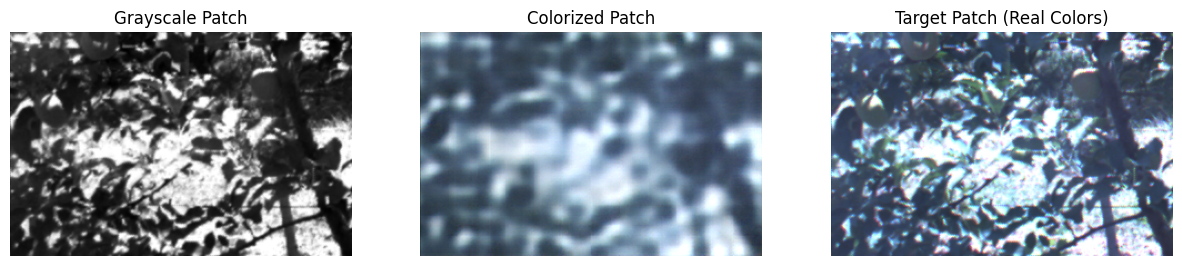

In [14]:
from utils.functions import *
model = MobileNetV2Colorization()
# Load the weights trained
model.load_state_dict(torch.load('weights/MobileColorizationMSE.pt', weights_only=True))  # Load the saved weights.
model.eval()  # Set the model to evaluation mode.

# We use the function to display a random pic in the dataset, evaluating it with the model saved
display_colorization_prediction(model, colorizationDataset, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08266534..1.2769752].


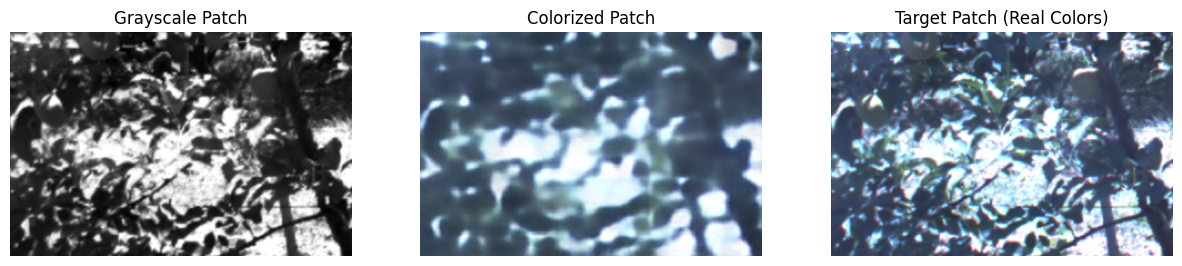

In [12]:
from utils.functions import *
model = VGG16Colorization()
# Load the weights trained
model.load_state_dict(torch.load('weights/appleColorizationMAE.pt', weights_only=True))  # Load the saved weights.
model.eval()  # Set the model to evaluation mode.

# We use the function to display a random pic in the dataset, evaluating it with the model saved
display_colorization_prediction(model, colorizationDataset,4)

 ## EDGE
 

In [ ]:
from src.EdgeDataset import Edgedataset
edgeDataset = Edgedataset(dataset)

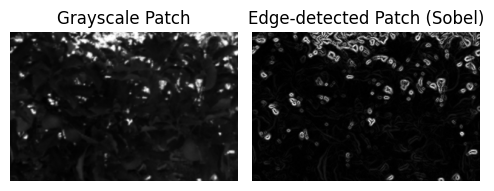

In [ ]:
edgeDataset.show(1) #example on how the dataset looks like

In [ ]:
from torch.utils.data import random_split, DataLoader
# Define the split proportions
train_ratio = 0.8  # 80% for training, 20% for validation

# Calculate sizes for train and validation datasets
dataset_size = len(edgeDataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

batch_size = 16

# Perform the split
train_dataset, val_dataset = random_split(edgeDataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 5926
Validation dataset size: 1482


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class MobileNetV2Edge(nn.Module):
    def __init__(self):
        super(MobileNetV2Edge, self).__init__()
        
        # Load pre-trained MobileNetV2 model
        mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        
        # Use the feature extractor part of MobileNetV2
        self.encoder = mobilenet_v2.features
        
        # Create decoder network
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1), 
        )
        
        self.final_adjustment = nn.AdaptiveAvgPool2d((202, 308))

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Encode
        features = self.encoder(x)
        # Decode
        output = self.decoder(features)
        output = self.final_adjustment(output)
        return output


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2Edge().to(device)
criterion = torch.nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [ ]:
num_epochs = 30
best_val = float('inf')
#best_val = 0.0055

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm.tqdm(train_loader):
    # Caricamento dei dati
        grayscale_patches = batch['gray'].to(device)  # Patch gray scale
        target_edges = batch['edge'].to(device)  # Ground truth (edge map)

        # Forward pass
        outputs = model(grayscale_patches)
        optimizer.zero_grad()

        # Calcolo della loss
        loss = criterion(outputs, target_edges)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            grayscale_patches = batch['gray'].to(device)  # Patch gray scale
            target_edges = batch['edge'].to(device)  # Ground truth (edge map)
            output = model(grayscale_patches)
            val_loss += criterion(output, target_edges)
        val_loss /= len(val_loader)
        if val_loss < best_val:
            torch.save(model.state_dict(), 'weights/MobileEdge.pt')
            best_val = val_loss
            print("Saved Weights")

    #results log
    print(f'Epoch {epoch+1} ---- training loss: {train_loss:.4f} ---- validation loss: {val_loss:.4f}')
        

In [ ]:
state_dict = torch.load('weights/MobileEdge.pt', map_location='cuda')
model = MobileNetV2Edge().to(device)
model.load_state_dict(state_dict)
sample = edgeDataset[0]
display_edge_prediction(model, sample, device)

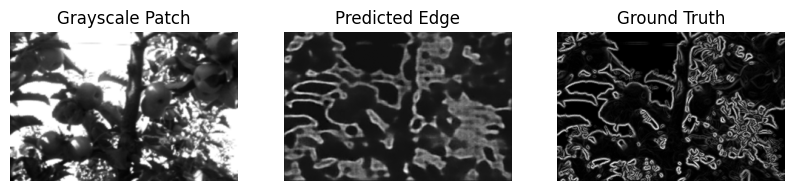

In [27]:
state_dict = torch.load('weights/appleEdge.pt', map_location='cuda')
model = VGG16Edge().to(device)
model.load_state_dict(state_dict)
sample = edgeDataset[0]
display_edge_prediction(model, sample, device)